In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, log_loss
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

# Data import and a little insight

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")

In [4]:
test_id = test_df["id"]

In [5]:
train_df

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1


In [6]:
train_df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [7]:
train_df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [8]:
train_df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Normally (and with my personal experience), these features can tells if a person is smoking or not:

- Blood creatinine + urine protein (kidney diseases)
- Blood sugar + eyesight (diabetes)
- Systolic BP - high BP

To be sure, I'll need to run PCA on all 24 features.

In [9]:
def preprocessing(df):
    # Calculate BMI
#     df["BMI"] = df["weight(kg)"] / ((df["height(cm)"] / 100) ** 2)
    
#     # Calculate eGFR (for kidney disease)
#     df["eGFR"] = (140 - df["age"]) * df["weight(kg)"] / (72 * df["serum creatinine"])
    
    df = df.drop([
        "id",
#         "age",
#         "weight(kg)",
#         "height(cm)",
#         "serum creatinine"
    ], axis=1)
    
    return df

In [10]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [11]:
train_df

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,...,55,80,14.4,1,1.1,22,17,37,0,1


In [12]:
# train_df["serum creatinine"].describe()

In [13]:
# train_df[(train_df["eGFR"] > 120) & (train_df["smoking"] == 1)]

In [14]:
# train_df["eGFR"].describe()

In [15]:
# train_df["serum creatinine"]

In [16]:
# train_df[train_df["smoking"] == 1].plot.scatter(x = "Urine protein", y = "serum creatinine")
# plt.show()

In [17]:
# train_df[train_df["smoking"] == 1].plot.scatter(x = "eGFR", y = "BMI")
# plt.plot()

In [18]:
train_X = train_df.drop(["smoking"], axis=1)
train_y = train_df["smoking"]

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_X_std = sc.fit_transform(train_X)

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA()
train_X_PCA = pca.fit_transform(train_X_std)

In [22]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

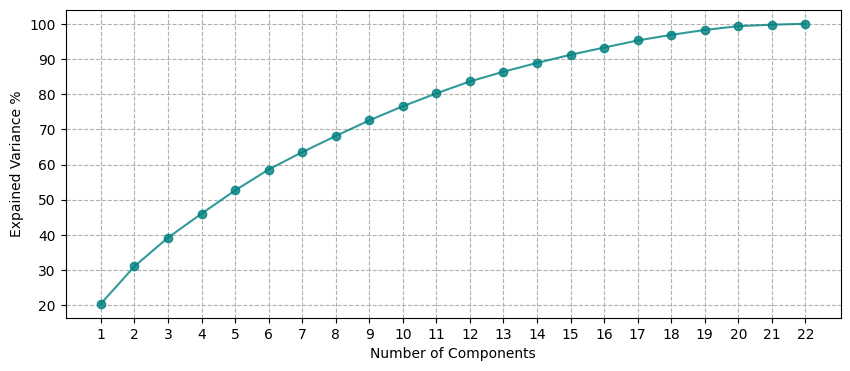

In [23]:
fig = plt.figure(figsize = (10,4))
plt.plot(np.arange(1, train_X_std.shape[1]+1),100 * cum_sum_eigenvalues, marker = 'o',
         color = 'teal', alpha = .8)
plt.xticks(np.arange(1, train_X_std.shape[1]+1),np.arange(1, train_X_std.shape[1]+1))
plt.xlabel('Number of Components')
plt.ylabel('Expained Variance %')
plt.grid(linestyle = '--')

plt.show()

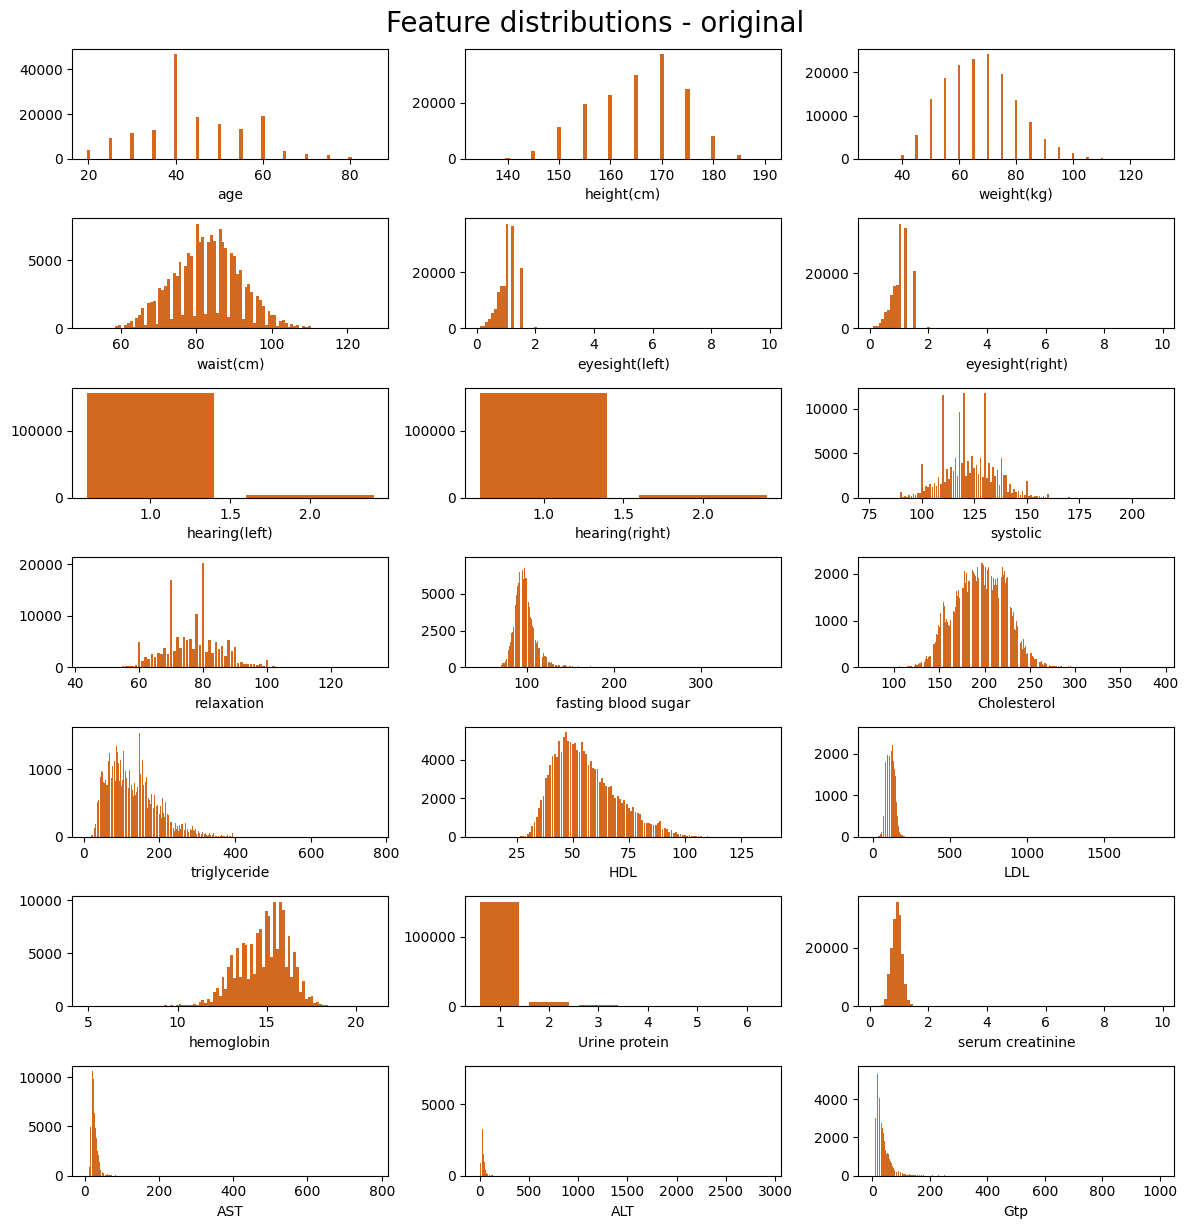

In [24]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(train_X.columns, axs.ravel()):
    if train_X[col].dtype == float:
        ax.hist(train_X[col], bins=100, color='chocolate')
    else: #int
        vc = train_X[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions - original', y=1.02, fontsize=20)
plt.show()

So the best option is to use all? True!

In [25]:
import seaborn as sns

In [26]:
estimators = [
    ("lr", LogisticRegression()),
    ("xgb", XGBClassifier()),
    ("lgb", lgb.LGBMClassifier()),
    ("gb", GradientBoostingClassifier()),
    ("cat", CatBoostClassifier())
]

In [27]:
pipes = {}

for model in estimators:
    print(f"Fitting {model[0]}")
    
    pipe = Pipeline(steps=[
#         ("std_scaler", StandardScaler()),
        model
    ])
    pipe.fit(train_X, train_y)
    pipes[pipe.steps[0][0]] = pipe

Fitting lr


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting xgb
Fitting lgb
Fitting gb
Fitting cat
Learning rate set to 0.08979
0:	learn: 0.6489902	total: 89ms	remaining: 1m 28s
1:	learn: 0.6145304	total: 119ms	remaining: 59.6s
2:	learn: 0.5880194	total: 148ms	remaining: 49.1s
3:	learn: 0.5667795	total: 176ms	remaining: 43.9s
4:	learn: 0.5506488	total: 205ms	remaining: 40.9s
5:	learn: 0.5373896	total: 234ms	remaining: 38.8s
6:	learn: 0.5264975	total: 263ms	remaining: 37.3s
7:	learn: 0.5180932	total: 294ms	remaining: 36.4s
8:	learn: 0.5108157	total: 322ms	remaining: 35.4s
9:	learn: 0.5051840	total: 350ms	remaining: 34.7s
10:	learn: 0.5001505	total: 379ms	remaining: 34s
11:	learn: 0.4960819	total: 406ms	remaining: 33.4s
12:	learn: 0.4926514	total: 436ms	remaining: 33.1s
13:	learn: 0.4894792	total: 464ms	remaining: 32.7s
14:	learn: 0.4865395	total: 490ms	remaining: 32.1s
15:	learn: 0.4838556	total: 520ms	remaining: 32s
16:	learn: 0.4818293	total: 550ms	remaining: 31.8s
17:	learn: 0.4796122	total: 580ms	remaining: 31.6s
18:	learn: 0.4776984

In [28]:
estimator_names = [model[0] for model in estimators]

In [29]:
def plot_estimators(estimators=estimator_names, 
                    X=train_X,
                    y=train_y,
                   n_splits=5,
                   metrics=["auc", "log_loss"]):
    metrics = {
        key: _metrics[key] for key in metrics
    }
    
    scorer, labels = [], []
    
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe = pipes[pipe_name]
            
            print(pipe)
            
            labels.append(pipe_name)
            
            kf = KFold(n_splits)
            
            model_score = cross_validate(pipe, X, y, scoring=metrics, cv=kf, n_jobs=4)
            
            scorer.append(model_score)
    
    score_lists = {}
    
    for metric in metrics:
        score_lists[metric] = [score[f"test_{metric}"] for score in scorer]
        
    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot = sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [30]:
metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

_metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

Pipeline(steps=[('lr', LogisticRegression())])


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_para

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Learning rate set to 0.08163
0:	learn: 0.6528885	total: 295ms	remaining: 4m 54s
1:	learn: 0.6204951	total: 507ms	remaining: 4m 13s
2:	learn: 0.5961172	total: 706ms	remaining: 3m 54s
3:	learn: 0.5764590	total: 911ms	remaining: 3m 46s
4:	learn: 0.5584677	total: 1.12s	remaining: 3m 42s
5:	learn: 0.5447239	total: 1.33s	remaining: 3m 40s
6:	learn: 0.5344122	total: 1.53s	remaining: 3m 37s
7:	learn: 0.5259197	total: 1.74s	remaining: 3m 36s
8:	learn: 0.5182548	total: 1.94s	remaining: 3m 34s
9:	learn: 0.5117923	total: 2.16s	remaining: 3m 33s
10:	learn: 0.5061932	total: 2.35s	remaining: 3m 30s
11:	learn: 0.5011664	total: 2.54s	remaining: 3m 29s
12:	learn: 0.4975144	total: 2.75s	remaining: 3m 28s
13:	learn: 0.4936753	total: 2.93s	remaining: 3m 26s
14:	learn: 0.4902157	total: 3.13s	remaining: 3m 25s
15:	learn: 0.4873305	total: 3.34s	remaining: 3m 25s
16:	learn: 0.4848339	total: 3.52s	remaining: 3m 23s
17:	learn: 0.4830968	total: 3.71s	remaining: 3m 22s
18:	learn: 0.4813347	total: 3.92s	remaining: 

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



928:	learn: 0.4015849	total: 2m 48s	remaining: 12.9s
929:	learn: 0.4015389	total: 2m 48s	remaining: 12.7s
930:	learn: 0.4015067	total: 2m 48s	remaining: 12.5s
931:	learn: 0.4014719	total: 2m 48s	remaining: 12.3s
932:	learn: 0.4014335	total: 2m 49s	remaining: 12.1s
933:	learn: 0.4013917	total: 2m 49s	remaining: 12s
934:	learn: 0.4013396	total: 2m 49s	remaining: 11.8s
935:	learn: 0.4012822	total: 2m 49s	remaining: 11.6s
936:	learn: 0.4012501	total: 2m 49s	remaining: 11.4s
937:	learn: 0.4012040	total: 2m 49s	remaining: 11.2s
938:	learn: 0.4011528	total: 2m 50s	remaining: 11.1s
939:	learn: 0.4011052	total: 2m 50s	remaining: 10.9s
940:	learn: 0.4010748	total: 2m 50s	remaining: 10.7s
941:	learn: 0.4010369	total: 2m 50s	remaining: 10.5s
942:	learn: 0.4009717	total: 2m 50s	remaining: 10.3s
943:	learn: 0.4009216	total: 2m 51s	remaining: 10.2s
944:	learn: 0.4008802	total: 2m 51s	remaining: 9.97s
945:	learn: 0.4008388	total: 2m 51s	remaining: 9.79s
946:	learn: 0.4007922	total: 2m 51s	remaining: 9

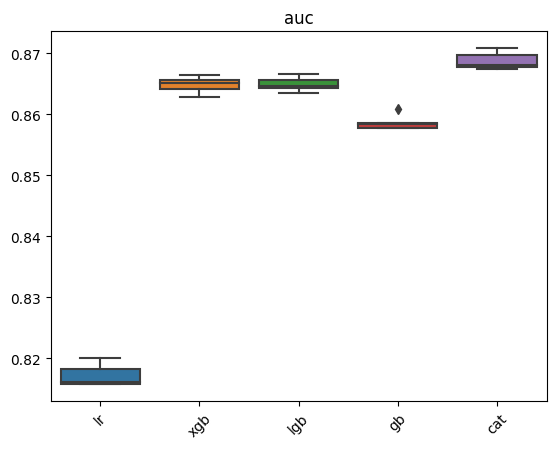

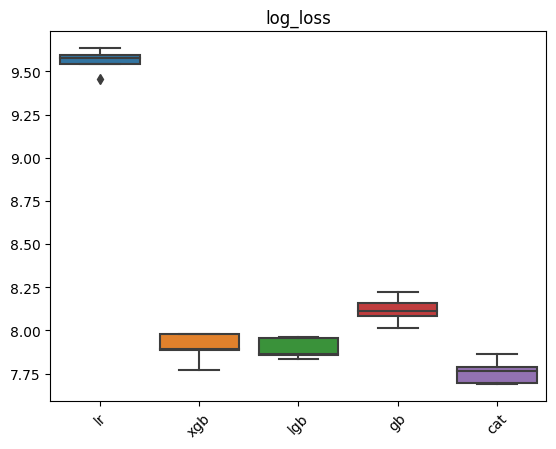

In [31]:
plot_estimators()

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Plotting lr
Plotting xgb
928:	learn: 0.4013384	total: 2m 49s	remaining: 12.9s
929:	learn: 0.4012920	total: 2m 49s	remaining: 12.8s
930:	learn: 0.4012497	total: 2m 49s	remaining: 12.6s
931:	learn: 0.4012161	total: 2m 49s	remaining: 12.4s
932:	learn: 0.4011666	total: 2m 50s	remaining: 12.2s
933:	learn: 0.4011379	total: 2m 50s	remaining: 12s
934:	learn: 0.4010838	total: 2m 50s	remaining: 11.8s
935:	learn: 0.4010519	total: 2m 50s	remaining: 11.7s
936:	learn: 0.4010219	total: 2m 50s	remaining: 11.5s
937:	learn: 0.4010055	total: 2m 50s	remaining: 11.3s
938:	learn: 0.4009745	total: 2m 51s	remaining: 11.1s
939:	learn: 0.4009539	total: 2m 51s	remaining: 10.9s
940:	learn: 0.4009239	total: 2m 51s	remaining: 10.7s
941:	learn: 0.4008922	total: 2m 51s	remaining: 10.6s
942:	learn: 0.4008362	total: 2m 51s	remaining: 10.4s
943:	learn: 0.4007934	total: 2m 51s	remaining: 10.2s
944:	learn: 0.4007724	total: 2m 52s	remaining: 10s
945:	learn: 0.4007216	total: 2m 52s	remaining: 9.83s
946:	learn: 0.4006840	tot

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



863:	learn: 0.4037815	total: 1m 43s	remaining: 16.4s
864:	learn: 0.4037386	total: 1m 44s	remaining: 16.2s
865:	learn: 0.4036977	total: 1m 44s	remaining: 16.1s
866:	learn: 0.4036387	total: 1m 44s	remaining: 16s
867:	learn: 0.4036178	total: 1m 44s	remaining: 15.9s
868:	learn: 0.4035858	total: 1m 44s	remaining: 15.8s
869:	learn: 0.4035346	total: 1m 44s	remaining: 15.6s
870:	learn: 0.4034993	total: 1m 44s	remaining: 15.5s
871:	learn: 0.4034627	total: 1m 44s	remaining: 15.4s
872:	learn: 0.4034308	total: 1m 45s	remaining: 15.3s
873:	learn: 0.4033894	total: 1m 45s	remaining: 15.2s
874:	learn: 0.4033519	total: 1m 45s	remaining: 15s
875:	learn: 0.4032909	total: 1m 45s	remaining: 14.9s
876:	learn: 0.4032362	total: 1m 45s	remaining: 14.8s
877:	learn: 0.4032006	total: 1m 45s	remaining: 14.7s
878:	learn: 0.4031643	total: 1m 45s	remaining: 14.6s
879:	learn: 0.4031226	total: 1m 45s	remaining: 14.4s
880:	learn: 0.4030669	total: 1m 45s	remaining: 14.3s
881:	learn: 0.4030382	total: 1m 46s	remaining: 14.

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


331:	learn: 0.4276267	total: 48.5s	remaining: 1m 37s
332:	learn: 0.4275266	total: 48.7s	remaining: 1m 37s
333:	learn: 0.4274459	total: 48.8s	remaining: 1m 37s
334:	learn: 0.4273624	total: 49s	remaining: 1m 37s
335:	learn: 0.4273252	total: 49.1s	remaining: 1m 37s
336:	learn: 0.4272775	total: 49.3s	remaining: 1m 36s
337:	learn: 0.4271788	total: 49.4s	remaining: 1m 36s
338:	learn: 0.4271156	total: 49.5s	remaining: 1m 36s
339:	learn: 0.4270591	total: 49.7s	remaining: 1m 36s
340:	learn: 0.4269782	total: 49.8s	remaining: 1m 36s
341:	learn: 0.4268855	total: 50s	remaining: 1m 36s
342:	learn: 0.4268085	total: 50.1s	remaining: 1m 35s
343:	learn: 0.4267369	total: 50.2s	remaining: 1m 35s
344:	learn: 0.4266365	total: 50.4s	remaining: 1m 35s
345:	learn: 0.4265604	total: 50.5s	remaining: 1m 35s
346:	learn: 0.4265242	total: 50.7s	remaining: 1m 35s
347:	learn: 0.4264686	total: 50.8s	remaining: 1m 35s
348:	learn: 0.4263909	total: 50.9s	remaining: 1m 35s
349:	learn: 0.4262941	total: 51.1s	remaining: 1m 3

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



486:	learn: 0.4171516	total: 1m 10s	remaining: 1m 14s
487:	learn: 0.4171017	total: 1m 10s	remaining: 1m 14s
488:	learn: 0.4170454	total: 1m 11s	remaining: 1m 14s
489:	learn: 0.4169968	total: 1m 11s	remaining: 1m 14s
490:	learn: 0.4169120	total: 1m 11s	remaining: 1m 13s
491:	learn: 0.4168775	total: 1m 11s	remaining: 1m 13s
492:	learn: 0.4168069	total: 1m 11s	remaining: 1m 13s
493:	learn: 0.4167394	total: 1m 11s	remaining: 1m 13s
494:	learn: 0.4166825	total: 1m 11s	remaining: 1m 13s
495:	learn: 0.4166277	total: 1m 12s	remaining: 1m 13s
496:	learn: 0.4165459	total: 1m 12s	remaining: 1m 13s
497:	learn: 0.4164948	total: 1m 12s	remaining: 1m 12s
498:	learn: 0.4164485	total: 1m 12s	remaining: 1m 12s
499:	learn: 0.4164108	total: 1m 12s	remaining: 1m 12s
500:	learn: 0.4163600	total: 1m 12s	remaining: 1m 12s
501:	learn: 0.4163086	total: 1m 12s	remaining: 1m 12s
502:	learn: 0.4162190	total: 1m 13s	remaining: 1m 12s
503:	learn: 0.4162036	total: 1m 13s	remaining: 1m 11s
504:	learn: 0.4161300	total:

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



425:	learn: 0.3990869	total: 17.7s	remaining: 23.8s
426:	learn: 0.3990294	total: 17.7s	remaining: 23.8s
427:	learn: 0.3988599	total: 17.7s	remaining: 23.7s
428:	learn: 0.3986644	total: 17.8s	remaining: 23.7s
429:	learn: 0.3984840	total: 17.8s	remaining: 23.6s
430:	learn: 0.3983304	total: 17.9s	remaining: 23.6s
431:	learn: 0.3981728	total: 17.9s	remaining: 23.6s
432:	learn: 0.3980059	total: 17.9s	remaining: 23.5s
433:	learn: 0.3978555	total: 18s	remaining: 23.4s
434:	learn: 0.3976815	total: 18s	remaining: 23.4s
435:	learn: 0.3975517	total: 18.1s	remaining: 23.4s
436:	learn: 0.3973526	total: 18.1s	remaining: 23.3s
437:	learn: 0.3972269	total: 18.1s	remaining: 23.3s
438:	learn: 0.3970779	total: 18.2s	remaining: 23.2s
439:	learn: 0.3969274	total: 18.2s	remaining: 23.2s
440:	learn: 0.3967972	total: 18.2s	remaining: 23.1s
441:	learn: 0.3966968	total: 18.3s	remaining: 23.1s
442:	learn: 0.3965371	total: 18.3s	remaining: 23s
443:	learn: 0.3963640	total: 18.4s	remaining: 23s
444:	learn: 0.396123

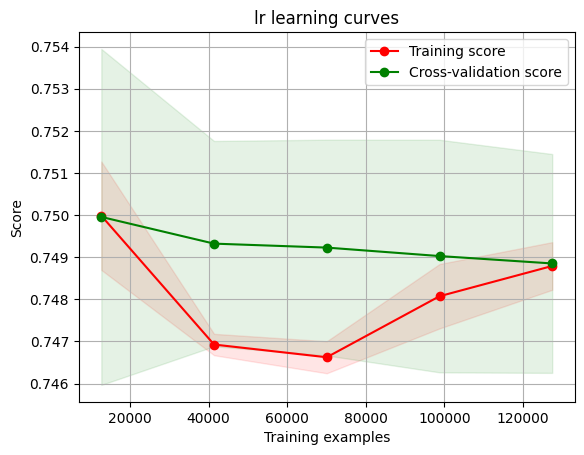

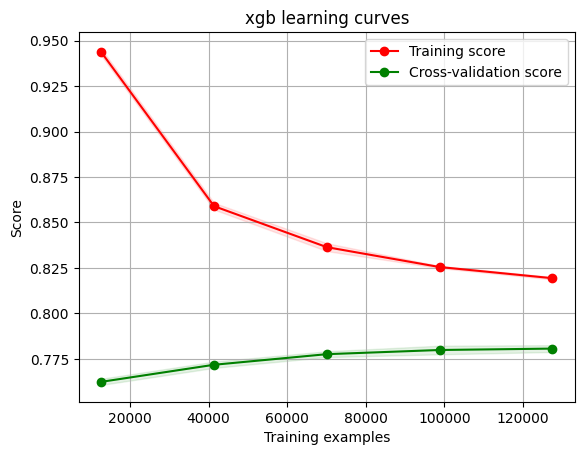

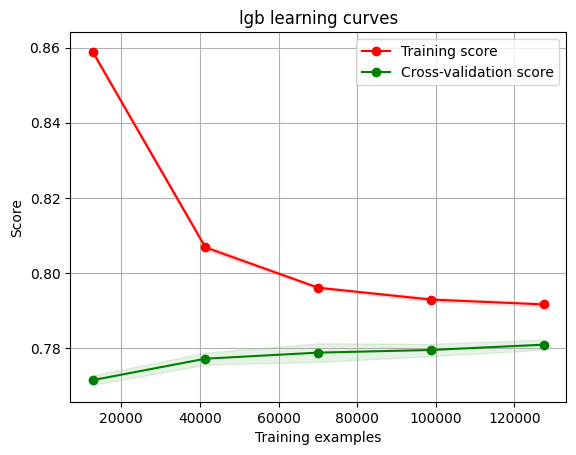

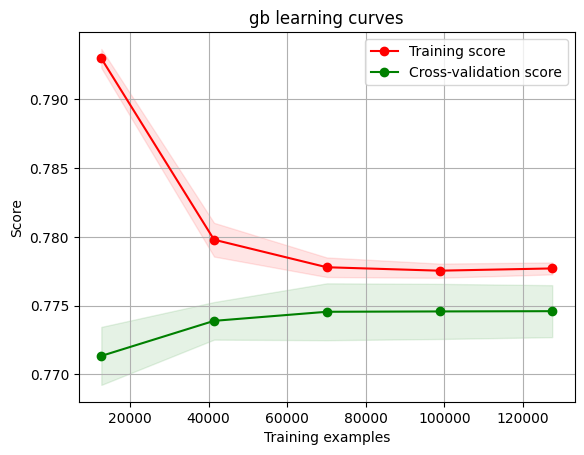

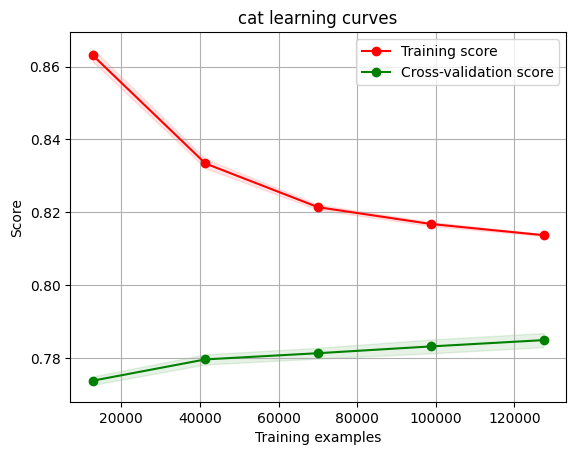

In [33]:
to_plot = [
    "xgb",
    "lgb",
    "gb",
    "lr",
    "cat"
]

for name in pipes.keys():
    if name in to_plot:
        print(f"Plotting {name}")
        g = plot_learning_curve(
            pipes[name].named_steps[name],
            f"{name} learning curves",
            train_X_std,
            train_y,
            cv=KFold(5),
            n_jobs=4
        )

<Axes: >

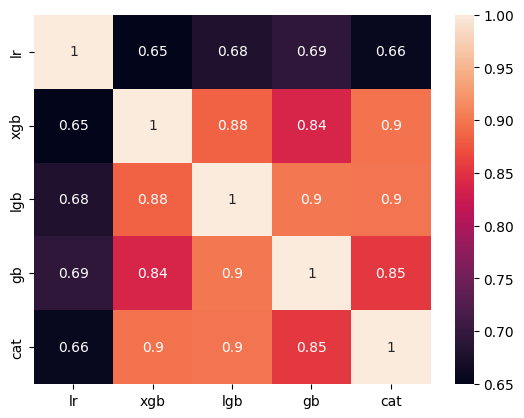

In [34]:
ensemble_results = pd.DataFrame()

for name, pipe in pipes.items():
    ensemble_results[name] = pipe.predict(train_X)
    
sns.heatmap(ensemble_results.corr(), annot=True)

## Voting

In [35]:
vote = Pipeline([
#     ("std_scaler", StandardScaler()),
    ("voter", VotingClassifier(estimators, 
                               voting="soft", 
                               n_jobs=4))
], verbose=True)

In [36]:
vote.fit(train_X, train_y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


923:	learn: 0.4018441	total: 3m 47s	remaining: 18.7s
924:	learn: 0.4017927	total: 3m 48s	remaining: 18.5s
925:	learn: 0.4017660	total: 3m 48s	remaining: 18.3s
926:	learn: 0.4017422	total: 3m 48s	remaining: 18s
927:	learn: 0.4017029	total: 3m 48s	remaining: 17.8s
928:	learn: 0.4016601	total: 3m 49s	remaining: 17.5s
929:	learn: 0.4016112	total: 3m 49s	remaining: 17.3s
930:	learn: 0.4015636	total: 3m 49s	remaining: 17s
931:	learn: 0.4015105	total: 3m 49s	remaining: 16.8s
932:	learn: 0.4014862	total: 3m 50s	remaining: 16.5s
933:	learn: 0.4014425	total: 3m 50s	remaining: 16.3s
934:	learn: 0.4014001	total: 3m 50s	remaining: 16s
935:	learn: 0.4013587	total: 3m 50s	remaining: 15.8s
936:	learn: 0.4013260	total: 3m 51s	remaining: 15.5s
937:	learn: 0.4012689	total: 3m 51s	remaining: 15.3s
938:	learn: 0.4012279	total: 3m 51s	remaining: 15s
939:	learn: 0.4011966	total: 3m 51s	remaining: 14.8s
940:	learn: 0.4011607	total: 3m 52s	remaining: 14.6s
941:	learn: 0.4011148	total: 3m 52s	remaining: 14.3s
9

Pipeline(steps=[('voter',
                 VotingClassifier(estimators=[('lr', LogisticRegression()),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             importan...
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)),
                                              ('lgb', LGBMClassifier()),
                                              ('gb',
                                               GradientBoostingClassifier()),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7c2f60284040>)],
                                  n_jobs=4, voting='soft'))],
         verbose=True)

In [37]:
pred_probs = vote.predict_proba(test_df)[:, 1]

In [38]:
pred_probs

array([0.55242805, 0.20785074, 0.48799134, ..., 0.41775679, 0.15466152,
       0.05069615])

In [39]:
submission_df = pd.DataFrame({
    "id": test_id,
    "defects": pred_probs
})

submission_df

,id,defects
0,159256,0.552428
1,159257,0.207851
2,159258,0.487991
3,159259,0.054380
4,159260,0.593346
...,...,...
106166,265422,0.522797
106167,265423,0.622133
106168,265424,0.417757
106169,265425,0.154662


In [40]:
submission_df.to_csv("submission.csv", index=False)